# Setup
## About this notebook
* This is the third notebook. It is focused on looking at ecoinvent through the lens of networks and is largely the same as the second notebook, just updated to use ecoinvent 3.11
* Author: Fitz Koch

## Import and Git


In [1]:
import bw2io as bi
import bw2data as bd
import bw2calc as bc
import git

import networkx as nx
from networkx.algorithms import bipartite
import random
from collections import defaultdict
from matplotlib import pyplot as plt 
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches


In [2]:
def get_git_root():
    repo = git.Repo(search_parent_directories=True)
    return repo.git.rev_parse("--show-toplevel")
root = get_git_root()

In [3]:
for m in bd.methods:
    print(m)


## Brightway setup

In [4]:
bd.projects.set_current('SEE_LAB') 
eidb = bd.Database("ecoinvent-3.11-cutoff")

# Exploration

## Brightway structure

In [5]:
random_act = eidb.random()
random_act.as_dict()

{'comment': "The process represents the treatment of 'municipal solid waste' in a municipal solid waste incinerator (MSWI). Recommended use of this dataset: municipal incineration of mixed municipal waste. Inventoried waste contains several fractions: 0.108% Textiles, leather, rubber; 0.376% newsprint; 6.36% sanitary products; 1.96% wood; 1% vacuum cleaner bags; 12.6% animal-derived food waste; 42.2% vegetable food waste; 0.000639% glass packaging-clear; 0.000106% glass packaging-green; 0.928% glass packaging-brown; 0.0858% kitchen and table ware glass; 0.0491% other/special glass; 0.303% ceramics; 1.15% cat litter; 2.92% metal packaging-non-ferrous; 3.53% metal packaging-ferrous; 1.32% non-packaging metal-ferrous; 1.94% non-packaging metal-non-ferrous; 0.24% plastic packaging-PET; 0.0956% non-packaging plastic-PP; 0.00849% non-packaging plastic-PET; 0.402% non-packaging plastic-no label; 0.183% plastic packaging-HDPE; 0.289% plastic packaging-PP; 0.0458% plastic packaging-PS; 0.0322% 

In [6]:
random_exc = [exc for exc in random_act.exchanges()][0].as_dict()
random_exc

{'flow': '45fbbc41-7ae9-46cc-bb31-abfa11e69de0',
 'type': 'production',
 'name': 'heat, for reuse in municipal waste incineration only',
 'classifications': {'CPC': ['17300: Steam and hot water']},
 'production volume': 967076944.429123,
 'properties': {'carbon allocation': {'amount': 0.0, 'unit': 'kg'},
  'carbon content': {'amount': 0.0, 'unit': 'dimensionless'},
  'price': {'amount': 0.0106,
   'comment': 'Average European district heat price from Ecoheatcool and Euroheat 2005-2006, Ecoheat Work package 1: The European heat market. Final report. 10.6 EUR/GJ i s the price of district heat. http://www.solarthermalworld.org/files/Ecoheatcool%20WP1%20Web.pdf?download',
   'unit': 'EUR2005'}},
 'activity': '031f2ee4-4645-5b0b-a9ad-c780104272b2',
 'unit': 'megajoule',
 'comment': 'net useful heat generated from this waste and used in internal MSWI plant energy redistribution. ',
 'amount': 1.0,
 'uncertainty type': 0,
 'loc': 1.0,
 'input': ('ecoinvent-3.11-cutoff', 'ae66eeb82767fb0fa1bfe

As we can see, each exchange stores an "input" and "ouput" var (when treated as a dict). 

Our goal is to use this exchange as an edge between the two nodes.

So first we'll get make just a node graph of all the processes (and maybe a bipartite network between biosphere and technosphere?)

And then we'll iterate through all the edges and join them.


**Note**: from the initial import as well as manually iterating (deleted), we know that t process count is 21238, while the exchange count is 674593 (for ecoinvent 3.9.1 -- but maybe we should upgrade to 3.11)



## Case study: make a graph from the database

In [7]:
G = nx.DiGraph()

## attach the nodes
for act in eidb:
    G.add_node(act['code'], **act)

G.number_of_nodes()

25412

In [8]:
random_node = random.choice(list(G.nodes))
G.nodes[random_node]

{'comment': 'Activity represents electricity production from coal gas treatment in power plants. Based on European data.\nThis dataset represents the treatment of coke oven gas (coal gas) in an unspecified gas power plant with high voltage electricity and heat as by-product in France in 2012.\nAccording to IEA (2008), coke oven gas is obtained as a by-product of solid fuel carbonisation and gasification operations carried out by coke producers and iron and steel plants not connected with gas works and municipal gas plants.\nThe efficiency calculations are based on IEA/OECD statistics (fuel inputs, electricity produced). No exergy correction could be made due to incomplete data (see ecoinvent report "Erdgas" p. 128 for details).\nWater is used for wet cooling and as feed water in the steam circuit. In this dataset, 100% wet cooling and no once-through cooling is assumed.  \nEMISSIONS:\nEmission data have partly been overtaken from a dataset representing the production of electricity in 

We can also look at this right from brightway

In [9]:
random_node = eidb.random()
print(random_node)
print(json.dumps(
    random_node.as_dict(), indent=4))

'market for esterquat' (kilogram, RoW, None)
{
    "comment": "This is a market activity. Each market represents the consumption mix of a product in a given geography, connecting suppliers with consumers of the same product in the same geographical area. Markets group the producers and also the imports of the product (if relevant) within the same geographical area. They also account for transport to the consumer and for the losses during that process, when relevant.\nThis is the market for  'esterquat', in the Global geography.\nIn this market, expert judgement was used to develop product specific transport distance estimations.\nesterquat'  are organic substances which consist of a quaternary ammonium cation and two fatty acid chains (C16-C18) with two weak ester linkages. They are solid under normal conditions of temperature and pressure. They are modelled as pure substances.  On a consumer level, they are used in the following products: fabric softeners. There is no publicly availab

In [10]:
def print_node(item):
    print(json.dumps(
    item.as_dict(), indent=4))

def print_dict(dict):
    print(json.dumps(dict, indent=4))

In [11]:
random_exc = [exc for exc in eidb.random().exchanges()][0]
print(random_exc)
print(json.dumps(
    random_exc.as_dict(), indent=4))

Exchange: 1.0 kilowatt hour 'electricity production, hydro, run-of-river' (kilowatt hour, CN-ZJ, None) to 'electricity production, hydro, run-of-river' (kilowatt hour, CN-ZJ, None)>
{
    "flow": "66c93e71-f32b-4591-901c-55395db5c132",
    "type": "production",
    "name": "electricity, high voltage",
    "classifications": {
        "CPC": [
            "17100: Electrical energy"
        ]
    },
    "production volume": 8013674504.372491,
    "properties": {
        "carbon allocation": {
            "amount": 0.0,
            "unit": "kg"
        },
        "carbon content": {
            "amount": 0.0,
            "unit": "dimensionless"
        },
        "heating value, net": {
            "amount": 0.0,
            "comment": "Infrastructure and services are assumed to have an LHV equal to zero (0).",
            "unit": "MJ"
        },
        "price": {
            "amount": 0.0977,
            "comment": "Temporary price data. Calculated as 90% of purchasers price based on: 9

Note that we have a choice of edge weight here. Possible options include:

* Production Volume -- how much is produced per yearso to speak. So maybe that means 482279000.0 kg of peanuts per annual year. 
* Any of the properties eg:
    * carbon acollocation 
    * carbon content
    * price 
    * amount -- the actual specific quantity. this is what is evaluated by impact assessment calculations.

But none of them *really* make sense to me to use. I suspect in the end we'll probably end up using different ones for different analysis for different types of processes.

I think probably the most sensible "standard," though, is amount. 



Either way, now we link the exchanges.

In [12]:
## Build the exchanges
for act in eidb:
    for exc in act.exchanges():
        input_node = exc["input"][1]
        output_node = exc["output"][1]
        weight = exc.get('Production Volume')
        carbon_content = exc.get('properties', {}).get('carbon content', {}).get('amount', 0)
        carbon_allocation = exc.get('properties', {}).get('carbon allocation', {}).get('amount', 1)
        
        # Calculate carbon flow for the edge
        carbon_flow = carbon_content * carbon_allocation
        # Add edge to the graph
        G.add_edge(input_node, output_node, carbon_flow=carbon_flow, weight=weight, **exc)



Now we can start looking at the nodes and edges in a more systematic way

In [13]:
out_edges = G.out_edges(random_node['code'], data=True)
for u, v, edge_data in out_edges:
    # Print edge info with formatted data
    edge_data_str = json.dumps(edge_data, indent=4)  # Pretty-print the edge data
    print(f"Edge from {u} to {v} with data:\n{edge_data_str}")
    print(f"\tHas location: {G.nodes[u].get('location', 'No location attribute')} \n")


Edge from 04887e987a3ea43476c76fcdd97d6965 to 2a72b5b250e100aec20ce7e5bbd42f9d with data:
{
    "carbon_flow": 0.5119758711671843,
    "weight": null,
    "flow": "b078cbaa-e4d8-49a0-afc7-78768258e79b",
    "type": "technosphere",
    "name": "esterquat",
    "classifications": {
        "CPC": [
            "35310: Organic surface active agents, except soap"
        ]
    },
    "production volume": 0.0,
    "properties": {
        "carbon allocation": {
            "amount": 0.715524892066785,
            "unit": "kg"
        },
        "carbon content": {
            "amount": 0.715524892066785,
            "unit": "dimensionless"
        },
        "carbon content, fossil": {
            "amount": 0.196746113547118,
            "unit": "dimensionless"
        },
        "carbon content, non-fossil": {
            "amount": 0.518778778519667,
            "unit": "dimensionless"
        },
        "dry mass": {
            "amount": 1.0,
            "unit": "kg"
        },
        "h

Interestingly, we get one MORE consuming (outgoing) edge than ecoquery suggests. One for the *market* for the low pressure gas and one that just goes back to itself. 


I'm not totally sure of this, but I think we can see [Brightway Inventory Documentation](https://docs.brightway.dev/en/latest/content/overview/inventory.html) for why:

"However, many databases we build on do not make a clean distinction between products and processes. In this case, to accurately reflect the data schema of the imported data, and to simplify graph traversal, we can create a chimaera node which is both process and reference product. In this case, a process produces itself, as it is both a process and a product. Because the product and process are bound together, these processes can only have one functional edge. These chimaera nodes have the data of both the process and the product, and the information of the (reference) product is given in Brightway by:

unit: The unit of the product produced

reference product: The name of the product produced"

This doesn't quite make sense, though, because we the text above has no reference product field.


Anyway, now we look at the incoming edges


In [14]:
incoming_edges = G.in_edges(random_node['code'], data=True)

for u, v, edge_data in incoming_edges:
    edge_data_str = json.dumps(edge_data, indent=4)  # Pretty-print the edge data
    print(f"Edge from {u} to {v} with data:\n{edge_data_str}")
    # print(f"Edge from {u} to {v} with data: {edge_data} \n\t has {G.nodes[u]['location']} as location")

print("\n")

Edge from 04887e987a3ea43476c76fcdd97d6965 to 04887e987a3ea43476c76fcdd97d6965 with data:
{
    "carbon_flow": 0.5119758711671843,
    "weight": null,
    "flow": "b078cbaa-e4d8-49a0-afc7-78768258e79b",
    "type": "production",
    "name": "esterquat",
    "classifications": {
        "CPC": [
            "35310: Organic surface active agents, except soap"
        ]
    },
    "production volume": 138300900.0,
    "properties": {
        "carbon allocation": {
            "amount": 0.715524892066785,
            "unit": "kg"
        },
        "carbon content": {
            "amount": 0.715524892066785,
            "unit": "dimensionless"
        },
        "carbon content, fossil": {
            "amount": 0.19674611354711802,
            "comment": "Esterquats are produced by esterification with triethanolamine and quaternication with DMS (ecoinvent v2.2 report 12-part 4). An average esterquat (Ester Quats: the novel class of cationic fabric softeners, Mishra, S. et al., 2007, Journa

In [15]:
def print_inc_edges(node):
    incoming_edges = G.in_edges(node, data=True)
    for u, v, edge_data in incoming_edges:
        edge_data_str = json.dumps(edge_data, indent=4)  # Pretty-print the edge data
        print(f"Edge from {u} to {v} with data:\n{edge_data_str}")
        # print(f"Edge from {u} to {v} with data: {edge_data} \n\t has {G.nodes[u]['location']} as location")

    print("\n")

Let's just iterate by following the first incoming edge for a while and see where we go.

In [16]:
def follow_first_edges(current_node, steps=50):
    # Start with the random node
    count = 0

    while count < steps:
        incoming_edges = list(G.in_edges(current_node, data=True))

        if not incoming_edges: 
            print(f"No more incoming edges for node {current_node}.")
            break

        
        try: u, v, edge_data = incoming_edges[0]
        except: 
            print("ran out of edges")
            break
        if u == v: ## often the first edge is self-referential (see above markdown note)
            try: u, v, edge_data = incoming_edges[1]
            except: 
                print("ran out of edges")
                break

        name1 = G.nodes[u].get('name')
        name2 = G.nodes[v].get('name')
        
        print(f"Edge from <{u}:{name1}> TO <{v}{name2}>")
        
        # Move to the previous node (incoming edge's source)
        current_node = u
        count += 1

    print("\n")

follow_first_edges(current_node = random_node['code'])


Edge from <e3e26200b02d93d883079755a49661d1:esterquat production, from coconut oil and palm kernel oil> TO <04887e987a3ea43476c76fcdd97d6965market for esterquat>
Edge from <2ab509c6b07b48093b151b50b1c0ace1:market for chemical factory, organics> TO <e3e26200b02d93d883079755a49661d1esterquat production, from coconut oil and palm kernel oil>
Edge from <86cdd2726a43b9980638c3592a6f2b57:chemical factory construction, organics> TO <2ab509c6b07b48093b151b50b1c0ace1market for chemical factory, organics>
Edge from <258ed9c1ce894b5ba0c593ebc5c35bd9:market for building, hall, steel construction> TO <86cdd2726a43b9980638c3592a6f2b57chemical factory construction, organics>
Edge from <2c0e0d881164481c06a3f71d3b6ceb9d:building construction, hall, steel construction> TO <258ed9c1ce894b5ba0c593ebc5c35bd9market for building, hall, steel construction>
Edge from <cde152d6ea2b95e5817989ca0d5ca7d9:market for aluminium, wrought alloy> TO <2c0e0d881164481c06a3f71d3b6ceb9dbuilding construction, hall, steel con

In [17]:
follow_first_edges(current_node=random.choice(list(G.nodes)))

Edge from <6c419ab45b44f79381c270d04426906b:market for limestone, crushed, washed> TO <501b559071f7120b429f040bedcca6b7treatment of leach residue from copper production, neutralisation>
Edge from <250c1b6062c1c71f2e28845df0155f18:limestone production, crushed, washed> TO <6c419ab45b44f79381c270d04426906bmarket for limestone, crushed, washed>
Edge from <366f05bf363a206d6d9d39bb19ebc718:market for conveyor belt> TO <250c1b6062c1c71f2e28845df0155f18limestone production, crushed, washed>
Edge from <1b3b7cafdd4b12154fcabc8390ff2b6f:conveyor belt production> TO <366f05bf363a206d6d9d39bb19ebc718market for conveyor belt>
Edge from <09b4ab4dd155d6b075045ef3a95b7b6b:market for concrete, normal strength> TO <1b3b7cafdd4b12154fcabc8390ff2b6fconveyor belt production>
Edge from <c006425878fc152dfd22cd16ef104e45:concrete, all types to generic market for concrete, normal strength> TO <09b4ab4dd155d6b075045ef3a95b7b6bmarket for concrete, normal strength>
Edge from <cea7e9e75ab39a7eede4b9b327e9d3ac:mark

Okay, this gives us a better sense of how the edges and nodes are operating, particularly the split between production and market. We're not choosing intelligently so its not the most revealing.

Note that there **do** seem to be motifs, or cyclical sub-networks, nested in here. If we just follow the first edge we **can** trapped in a cycle.

One thing we can expand to is following the heaviest weight.

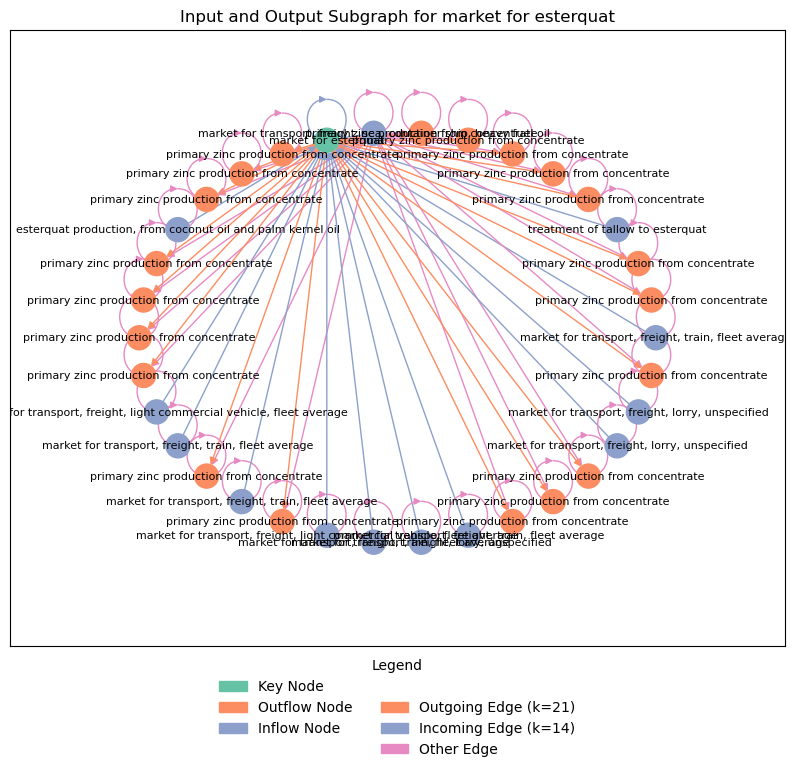

'04887e987a3ea43476c76fcdd97d6965'

In [18]:
def subgraph_node(highlight_node, path=None, labels=True, palette=None):

    ## Set up color scheme
    if not palette:
        palette = sns.color_palette("Set2", 4)


    outflow = set(G.successors(highlight_node))
    inflow = set(G.predecessors(highlight_node))
    sub_nodes = {highlight_node} | outflow | inflow
    subgraph = G.subgraph(sub_nodes)

    edges_to_draw = [(u, v) for u, v in subgraph.edges()]
    edge_weights = [subgraph[u][v].get('weight', 1) for u, v in edges_to_draw]

    node_colors = [
        palette[0] if n == highlight_node else
        palette[1] if n in outflow else
        palette[2] if n in inflow else
        palette[3] 
        for n in subgraph.nodes()
    ]

    edge_colors = [
        palette[2] if v == highlight_node else
        palette[1] if u == highlight_node else
        palette[3]
        for u, v in edges_to_draw
    ]

    labels = {
        n: data.get('name', 'No Name')
        for n, data in subgraph.nodes(data=True)
    }

    # Only layout that is working for some unclear reason
    pos = nx.circular_layout(subgraph)

    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors)
    nx.draw_networkx_edges(subgraph, pos, edgelist=edges_to_draw, width=edge_weights, edge_color=edge_colors)
    if labels:
        nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8)
        plt.xlim(-1.5, 1.5)  
        plt.ylim(-1.5, 1.5)  

    # Combined legend
    node_legend = [
        mpatches.Patch(color=palette[0], label='Key Node'),
        mpatches.Patch(color=palette[1], label='Outflow Node'),
        mpatches.Patch(color=palette[2], label='Inflow Node'),
        mpatches.Patch(color='none', label=''),  # Empty patch to fill out the column

        # mpatches.Patch(color=palette[3], label='Other Node')
    ]

    edge_legend = [
        mpatches.Patch(color='none', label=''),  # Empty patch to fill out the column
        mpatches.Patch(color=palette[1], label=f'Outgoing Edge (k={G.out_degree(highlight_node)})'),
        mpatches.Patch(color=palette[2], label=f'Incoming Edge (k={G.in_degree(highlight_node)})'),
        mpatches.Patch(color=palette[3], label='Other Edge')
    ]

    plt.legend(handles=node_legend + edge_legend, title="Legend", 
               loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False)
    
    plt.title(f"Input and Output Subgraph for {G.nodes[highlight_node]['name']}")

    if path:
        plt.savefig(path)

    
    plt.show()
    return highlight_node

subgraph_node(highlight_node=random_node['code'])


So whats with all these "no name" nodes? First, lets check if they are actually in brightway... 

In [19]:
highlight_node = random_node['code']
outflow = set(G.successors(highlight_node))
inflow = set(G.predecessors(highlight_node))
sub_nodes = {highlight_node} | outflow | inflow
subgraph = G.subgraph(sub_nodes)
for node, data in subgraph.nodes(data=True):
    try: print(node, data, eidb.get(node))
    except: print(f"{node}, {data} not in db")

f91c09a749ec056ab707935b0c454b49 {'comment': "This is a market activity. Each market represents the consumption mix of a product in a given geography, connecting suppliers with consumers of the same product in the same geographical area. Markets group the producers and also the imports of the product (if relevant) within the same geographical area. They also account for transport to the consumer and for the losses during that process, when relevant.\nThis is the market for  'transport, freight train', in the geography of India.\nThis market contains no transport or losses, as they are irrelevant for the delivered product.\nThis is delivering the service of transportation of 1 metric ton across the distance of 1 km. This service only considers the transportation of goods. The vehicle operates with diesel, electricity or gard coal, while it has a mass of 1000 Gt.  The transport node indirectly considers empty trips (if any) by taking into account the total amount of freight transported t

So these one's that are appearing as "not named" are not in the technosphere... why? Lets look more closely at one

In [20]:
print_inc_edges(highlight_node)

Edge from 04887e987a3ea43476c76fcdd97d6965 to 04887e987a3ea43476c76fcdd97d6965 with data:
{
    "carbon_flow": 0.5119758711671843,
    "weight": null,
    "flow": "b078cbaa-e4d8-49a0-afc7-78768258e79b",
    "type": "production",
    "name": "esterquat",
    "classifications": {
        "CPC": [
            "35310: Organic surface active agents, except soap"
        ]
    },
    "production volume": 138300900.0,
    "properties": {
        "carbon allocation": {
            "amount": 0.715524892066785,
            "unit": "kg"
        },
        "carbon content": {
            "amount": 0.715524892066785,
            "unit": "dimensionless"
        },
        "carbon content, fossil": {
            "amount": 0.19674611354711802,
            "comment": "Esterquats are produced by esterification with triethanolamine and quaternication with DMS (ecoinvent v2.2 report 12-part 4). An average esterquat (Ester Quats: the novel class of cationic fabric softeners, Mishra, S. et al., 2007, Journa

## Adding Biosphere as Multipartite graphs

Ah! When we ctrl-f for one of the naughty nodes it becomes obvious why it didn't show -- these are edges that originate in **biosphere** nodes.

So now we can recreate the network as a multipartite graph. We don't use the built in bipartite model because networkx doesn't allow for links between the same set and the technosphere definitely has to link to itself.

In [21]:
ei_biosphere = bd.Database("ecoinvent-3.11-biosphere")


In [22]:
random_bio = ei_biosphere.random()
print(json.dumps(random_bio.as_dict(), indent=4))

{
    "categories": [
        "water"
    ],
    "code": "13a88c9e-fffa-489d-a304-b5045d9b1655",
    "CAS number": "000100-18-5",
    "synonyms": [],
    "name": "1,4-Diisopropylbenzene",
    "database": "ecoinvent-3.11-biosphere",
    "unit": "kilogram",
    "type": "emission",
    "id": 32879
}


In [23]:
G = nx.DiGraph()

## attach the nodes
for act in eidb:
    G.add_node(act['code'], node_type='Technosphere', **act)
    for exc in act.exchanges():
        input_node = exc["input"][1]
        output_node = exc["output"][1]
        weight = exc.get('Production Volume')
        carbon_content = exc.get('properties', {}).get('carbon content', {}).get('amount', 0)
        carbon_allocation = exc.get('properties', {}).get('carbon allocation', {}).get('amount', 1)
        
        # Calculate carbon flow for the edge
        carbon_flow = carbon_content * carbon_allocation
        # Add edge to the graph
        G.add_edge(input_node, output_node, carbon_flow=carbon_flow, weight=weight, **exc)

for act in ei_biosphere:
    G.add_node(act['code'], node_type='Biosphere', **act)
    ## my understanding is that biosphere nodes don''t have exchanges so we can skip that

G.number_of_nodes()

35207

Now when we try to graph these we get all the names included.

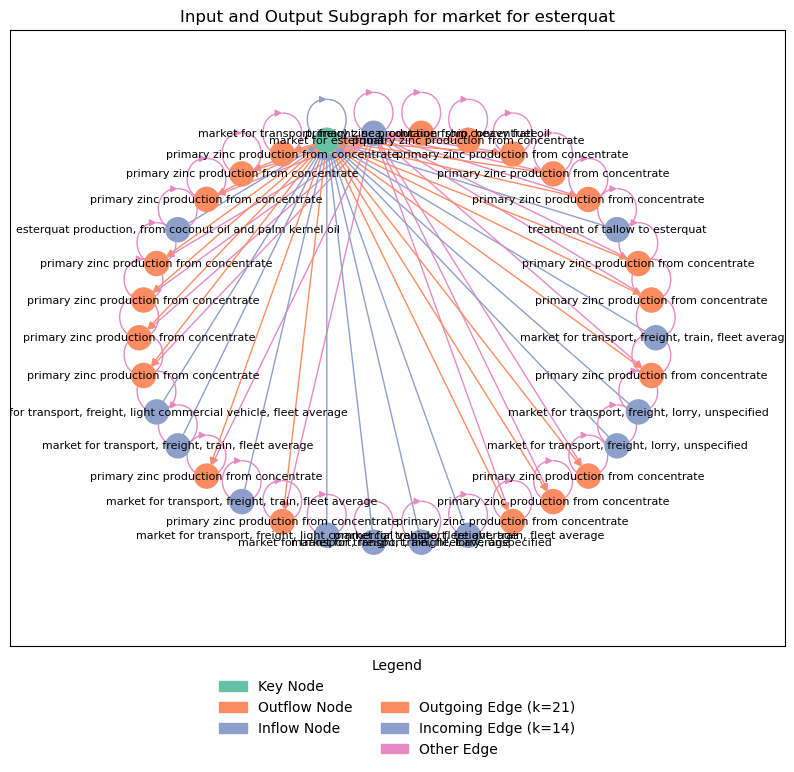

'04887e987a3ea43476c76fcdd97d6965'

In [24]:
subgraph_node(highlight_node=random_node['code'])

And for a newly generated node:

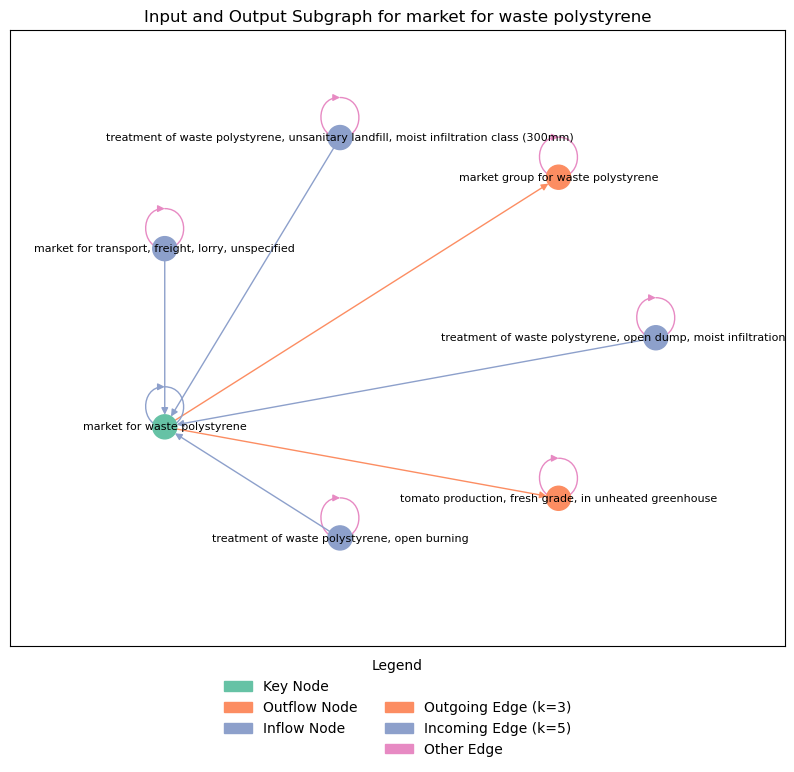

'2149fbdbc9bf21a075111d972f0aa89d'

In [25]:
technosphere_nodes = [n for n, attr in G.nodes(data=True) if attr['node_type'] == 'Technosphere']

# Select a random technosphere node
new_node = random.choice(technosphere_nodes)
subgraph_node(new_node)


In [55]:
def find_node_in_bw(id):
    try:
        b = eidb.get(id)
        # print(b)
        # b = b.as_dict()
        # print("technosphere", json.dumps(b, indent=4))
    except:
        try: 
                b = ei_biosphere.get(id)
                # print(b)
                # b = b.as_dict()
                # print("biosphere", json.dumps(b, indent=4))
        except:
            print(id)
            raise ValueError("Not Found")
    for exc in b.exchanges():
         print(exc)

with open(r"C:\Users\fitsl\Documents\Programming\SEE-Lab-LCA-Analyis\error_log.txt", "r") as f:
     data = f.readlines()
    
eidb = bd.Database("ecoinvent-3.9.1-cutoff")
ei_biosphere = bd.Database("ecoinvent-3.9.1-biosphere")



for line in data:
     line = str(line)
     line = line.strip()
     find_node_in_bw(line)

In [54]:
path = "0f70e720-127e-44dc-bb85-438158235ab6"

a = ei_biosphere.get(path)
print(json.dumps(a.as_dict() ,indent=4))
for exc in a.exchanges():
    print(exc)

{
    "categories": [
        "air",
        "lower stratosphere + upper troposphere"
    ],
    "code": "0f70e720-127e-44dc-bb85-438158235ab6",
    "CAS number": "000074-87-3",
    "synonyms": [
        "R-40",
        "chloromethane",
        "methyl chloride",
        "Methane, monochloro-",
        "Monochloromethane"
    ],
    "name": "Methane, monochloro-, R-40",
    "database": "ecoinvent-3.9.1-biosphere",
    "unit": "kilogram",
    "type": "emission",
    "id": 1650
}


In [27]:
-break

SyntaxError: invalid syntax (3890221310.py, line 1)

## Miscellaneous networkx stuff

See how the types work -- note that all the technosphere nodes are processes, while the biosphere nodes are more subdivided. We have emission, natural resource, inventory indicator, and economic nodes.

In [ ]:
# for node, data in G.nodes()
types = defaultdict(int)

for node, data in G.nodes(data=True):
    kind = data.get('node_type') 
    val = data.get("type")
    types[kind + ': ' + val] += 1

print_dict(types)


{
    "Technosphere: process": 25412,
    "Biosphere: emission": 9428,
    "Biosphere: natural resource": 347,
    "Biosphere: inventory indicator": 15,
    "Biosphere: economic": 5
}


## clustering

First, get a sense of the edge weight distribution. Recall from above that edge weight could be defined as:

* production volume
* any of the values in the carbon dict:
    * allocation*carbon amount (carbon flow)

Min Weight: 0.0
Max Weight: 40601489.5
Average Weight: 1845.1167814874789


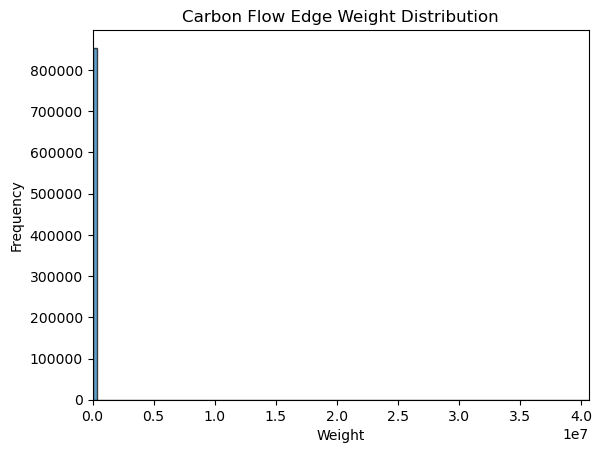

In [ ]:
weights = [data['carbon_flow'] for _, _, data in G.edges(data=True)]

# Print basic statistics
# print("agh")
# print("Edge Weights:", weights)
print("Min Weight:", min(weights))
print("Max Weight:", max(weights))
avg_weight =  sum(weights) / len(weights)
print("Average Weight:", avg_weight)


# Because there are some big big outliers, we can plot just to a low value.
# We also strip out 0-1 (minimal)
plt.hist(weights, bins=100, edgecolor='black', alpha=0.7)
plt.title("Carbon Flow Edge Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.xlim(0, max(weights))
plt.show()

Min Weight: 1.0000000000000007
Max Weight: 244.03600000000006
Average Weight: 92.23832089420513


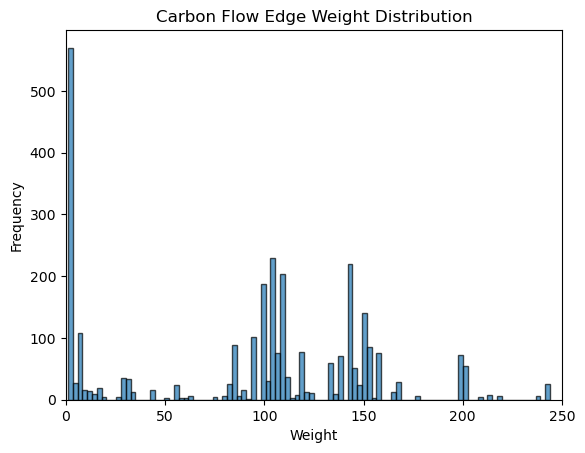

In [ ]:
weights = [data['carbon_flow'] for _, _, data in G.edges(data=True)]

# Print basic statistics
# print("agh")
# print("Edge Weights:", weights)
filtered_weights = [w for w in weights if 1 < w <= 250]
print("Min Weight:", min(filtered_weights))
print("Max Weight:", max(filtered_weights))
avg_weight =  sum(filtered_weights) / len(filtered_weights)
print("Average Weight:", avg_weight)


# Because there are some big big outliers, we can plot just to a low value.
# We also strip out 0-1 (minimal)
plt.hist(filtered_weights, bins=100, edgecolor='black', alpha=0.7)
plt.title("Carbon Flow Edge Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.xlim(0, 250)
plt.show()

Min Weight: 9.27474132871974e-103
Max Weight: 1.0
Average Weight: 0.3653083857758664


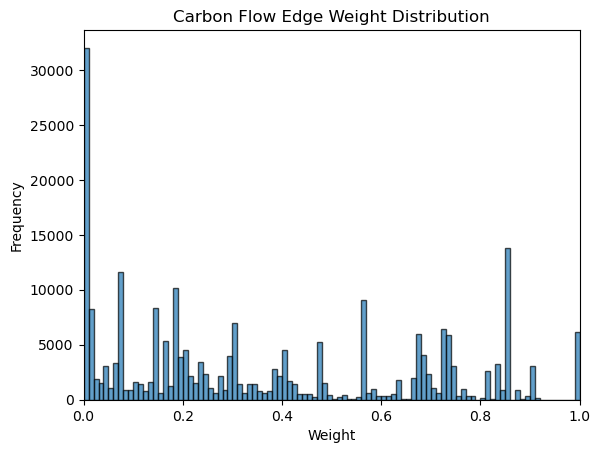

In [ ]:
weights = [data['carbon_flow'] for _, _, data in G.edges(data=True)]

# Print basic statistics
# print("agh")
# print("Edge Weights:", weights)
filtered_weights = [w for w in weights if 0 < w <= 1]

print("Min Weight:", min(filtered_weights))
print("Max Weight:", max(filtered_weights))
avg_weight =  sum(filtered_weights) / len(filtered_weights)
print("Average Weight:", avg_weight)


# Because there are some big big outliers, we can plot just to a low value.
# We also strip out 0-1 (minimal)
filtered_weights = [w for w in weights if 0 < w <= 1]
plt.hist(filtered_weights, bins=100, edgecolor='black', alpha=0.7)
plt.title("Carbon Flow Edge Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.show()

## Degree Characterization

In [ ]:
indegree_dict = defaultdict(int)
outdegree_dict = defaultdict(int)


for node in G.nodes():
    val = G.in_degree[node]
    indegree_dict[val] += 1
    val = G.out_degree[node]
    outdegree_dict[val] += 1

indegree_frame = pd.DataFrame(list(indegree_dict.items()), columns=['Degree', 'Count'])
indegree_frame.sort_values(by='Count', ascending=False).head(10)

,Degree,Count
15,0,9795
13,2,2578
5,3,2228
1,5,1712
4,6,1463
63,1,1363
9,4,1227
3,7,1110
2,8,623
31,10,613


In [ ]:

outdegree_frame = pd.DataFrame(list(outdegree_dict.items()), columns=['Degree', 'Count'])
outdegree_frame.sort_values(by='Count', ascending=False).head(10)

,Degree,Count
48,2,14670
661,0,6557
80,1,3056
35,3,2191
66,4,1034
73,5,547
232,6,384
18,7,262
31,9,217
69,10,196


In [ ]:
def counts_to_rank(counts):
    """
    Given a dataframe of raw counts, return a dataframe with the
    rank.
    """
    df = counts.copy()
    df = df[df['Count'] > 0]
    df['Rank'] = df['Count'].rank(ascending=False)
    return df


In [ ]:
indegree_rank = counts_to_rank(indegree_frame)
indegree_rank.sort_values(by='Count', ascending=False).head(20)



,Degree,Count,Rank
15,0,9795,1.0
13,2,2578,2.0
5,3,2228,3.0
1,5,1712,4.0
4,6,1463,5.0
63,1,1363,6.0
9,4,1227,7.0
3,7,1110,8.0
2,8,623,9.0
31,10,613,10.0


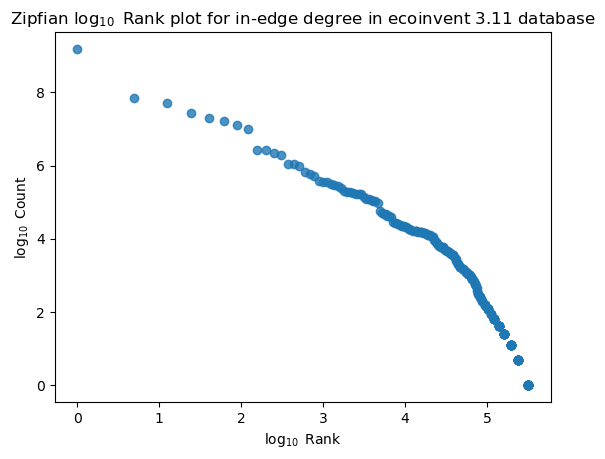

In [ ]:
sns.regplot(data=indegree_rank.apply(np.log), y='Count', x='Rank', fit_reg=False)
plt.title(r"Zipfian $\log_{10}$ Rank plot for in-edge degree in ecoinvent 3.11 database")
plt.xlabel(r"$\log_{10}$ Rank")
plt.ylabel(r"$\log_{10}$ Count")
plt.savefig(f"{root}/Figures/Basic_Viz/network_casestudy/zipf_indegree_plot_3.11.png")

In [ ]:
outdegree_rank = counts_to_rank(outdegree_frame)
outdegree_rank.sort_values(by='Count', ascending=False).head(20)

,Degree,Count,Rank
48,2,14670,1.0
661,0,6557,2.0
80,1,3056,3.0
35,3,2191,4.0
66,4,1034,5.0
73,5,547,6.0
232,6,384,7.0
18,7,262,8.0
31,9,217,9.0
69,10,196,10.0


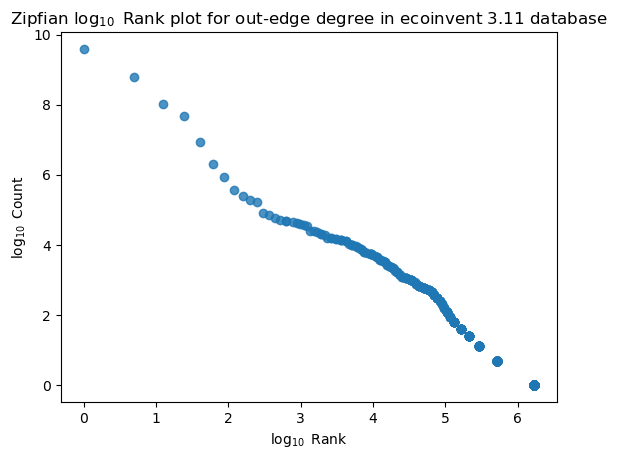

In [ ]:
sns.regplot(data=outdegree_rank.apply(np.log), y='Count', x='Rank', fit_reg=False)
plt.title(r"Zipfian $\log_{10}$ Rank plot for out-edge degree in ecoinvent 3.11 database")
plt.xlabel(r"$\log_{10}$ Rank")
plt.ylabel(r"$\log_{10}$ Count")
plt.savefig(f"{root}/Figures/Basic_Viz/network_casestudy/zipf_outdegree_plot_3.11.png")

In [ ]:
max_degree_node = max(G.degree, key=lambda x: x[1])[0]
G.nodes(max_degree_node)

NodeDataView({'21e83275741eabaa4d4cbccd116ddc60': None, '10c156c0e0b6f44a24d4c47971a62f3c': None, 'c93ffd72802a0dd025c81c4565650cc5': None, 'cd543ba24c56bda8642a8f920d72e102': None, '3cb1c6c8283bcfe495d969be26c4ce27': None, '628434d380c58f36b7231d7baf399a01': None, '7537d5b28704219c05bfc9b333a2b3d1': None, '1a0a960396612c453d4f4c4e374959f6': None, 'e78076b58ae2c46720ae85a078bb2cbb': None, 'bd06cc3a9d58094906f9d97e13605eea': None, '7a4486a8173f0a13d767fecc3a19feb1': None, '1d618522bccc26383f76933de4fa7118': None, 'd3a4cfefa2b8f2df5f97d5d833e11ce6': None, '1cc30bbe5c8a8fae5df466dba884f0e3': None, '9e5bbe61aba9c3cee88bc99deb8920fc': None, 'ee946a2344d2f3e6e4969dcb87eb3be6': None, '65a58236d6164eb1ca4eb9c504156052': None, '82cf79d65e6f0ada87ae1631eb4cd173': None, '889a0518a1dd2dd9ada87652f3445bcd': None, '86f4cbb7e813252bc0db62bd761777d7': None, 'ee2fc15ead1b2be0bb34b21e12e600b6': None, 'c5f5aaeb30a5dbe1da16486d54ee18ad': None, '8d97d6b05a8f0092005d30897bc45db2': None, '93e67d1c3478e29188e

A differential characterization would be useful -- how 